In [1]:
#need some cutouts and coordinates
from astropy.nddata import Cutout2D
from astropy import coordinates
from astropy import units as u

#if you want to try this with various images, glob is the answer for finding files!
import glob
# filenames = glob.glob('../../Convolved_Images_Hub/*126_image*')
# print(filenames)

#some common packages
import numpy as np
from astropy import wcs
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.io import fits
from kneed import KneeLocator
import pandas as pd
from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
from reproject import reproject_interp
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
from scipy.special import expit
from scipy.misc import derivative
from scipy.optimize import curve_fit
import sys

#easiest option would be using a library...assuming it works...but it doesn't?:(
# from statsmodels.distributions.empirical_distribution import ECDF


In [2]:
#quick function to compute EDF given a data set
#following: https://cmdlinetips.com/2019/05/empirical-cumulative-distribution-function-ecdf-in-python/
def edf_calc(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / (n)
    
    #alt method from https://stackoverflow.com/questions/42147206/normalizing-cdf-in-python
    num_bins = 2500
    x = data[~np.isnan(np.sort(data))]
    counts, bin_edges = np.histogram(x, bins=num_bins, range=(np.nanmin(x), np.nanmax(x)), density=True)
    center = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate and plot CDF of sample 
    cdf = np.cumsum(counts)
    scale = 1.0/cdf[-1]
    norm_cdf = scale * cdf
    
    return(center, norm_cdf)

# This dictionary defines a colormap in case you want to make a unique colormap?
cdict = {'red':  ((0.0, 0.0, 0.0), (0.5, 1.0, 1.0), (1.0, 0.8, 0.8)), 'green': ((0.0, 0.8, 0.8), (0.5, 1.0, 1.0), (1.0, 0.0, 0.0)), 'blue':  ((0.0, 0.0, 0.0), (0.5, 1.0, 1.0), (1.0, 0.0, 0.0)) } # no red at 0
# all channels set to 1.0 at 0.5 to create white
# set to 0.8 so its not too bright at 1

# set to 0.8 so its not too bright at 0
# all channels set to 1.0 at 0.5 to create white
# no green at 1

# no blue at 0
# all channels set to 1.0 at 0.5 to create white
# no blue at 1


# Creating a colormap using the dictionary
import matplotlib.colors as colors
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)


#a plotting code to review what we're analyzing while in python
#data is the input data
#w is the wcs
#wcscond is True or False, True means the axes will be in RA/Dec, and False means axes in pixels
import matplotlib.pyplot as plt
def implot(data, w, wcscond, vmax_p):
    fig = plt.figure()

    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)

    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it's not bad
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=vmax_p)
    plt.xlabel('RA')
    plt.ylabel('Dec')


#determining cutout coordinates for each knot...so far just do it by eye and in pixel space
#could probably do it in wcs coords, RA/DEC, but I couldn't get that working

def file_open(file):
    hdu1 = fits.open(file)  #import image
    w = wcs.WCS(hdu1[0].header)   #get wcs coords
    data = hdu1[0].data  #getting data from hdu
    hdu1.close()

    return w, data


# https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
# https://stackoverflow.com/questions/59805561/python-using-curve-fit-to-fit-a-logarithmic-function
def edf_func(x, A, B, C, K, Q, nu):
#     return amplitude * 1.0/(1.0+np.exp(-x0*(x-k)))
    return A + (K - A) /(C + Q * np.exp(-B * x))**(1./ nu)

def edf_deriv_func(x, A, B, C, K, Q, nu):
    params = [A, B, C, K, Q, nu]
    return derivative(edf_func, x, dx=0.01, args=params)

def func_fitter(arrx_lim, arry_lim, sub_str, max_runs, p0=[], pdf_scale=1):
    #creating smooth curve - interpolating also can fit the data
    plt.figure(112)
    #     f = np.poly1d(pfit)  #interpolating function to be used
    #     plt.plot(arrx_lim, f(arrx_lim), linestyle='--')#, label= sub_str+'fit')
#     p0 = [max(arry_lim), np.median(arrx_lim),1,min(arry_lim)] # this is an mandatory initial guess
    popt, pcov = curve_fit(edf_func, arrx_lim, arry_lim, p0=p0, maxfev=max_runs)
    pfit = edf_func(arrx_lim, *popt) #np.polyfit(arrx_lim, arry_lim, dim)
    print(sub_str+' params', popt)#'stdev', np.sqrt((1./popt[1])**2. * np.pi**2. / 3.))  #taken from https://en.wikipedia.org/wiki/Generalised_logistic_function
    plt.plot(arrx_lim,pfit, color='black')#, label= sub_str+'fit')
#     tck,u = interpolate.splprep([arrx_lim, arry_lim],s=0)
#     new_points = interpolate.splev(u, tck)
#     plt.plot(arrx_lim,y_spl(arrx_lim), linestyle='--')#, label= sub_str+'fit')


    
    #plotting derivative to find turning point...
    plt.figure(113)
#     deriv_f = np.polyder(f)  #interpolating derivative of function to be used
#     plt.plot(arrx_lim, deriv_f(arrx_lim))#, label= sub_str+'fit')
    deriv1 = [derivative(edf_func, x, dx=0.01, args=popt) for x in arrx_lim]
    plt.plot(arrx_lim, np.array(deriv1) * pdf_scale, color = 'black')#, label= sub_str+'fit')
#     print(sub_str+' fit/sqrt(fit)', np.array(deriv1[-12:])/np.sqrt(deriv1[-12:]), arrx_lim[-12:])
#     u=np.linspace(0,1,num=50,endpoint=True)
#     out = interpolate.splev(u,tck,der=1)
#     plt.plot(arrx_lim,y_spl_1d(arrx_lim))#, label= sub_str+'fit')    
    plt.plot(arrx_lim, [0]*arrx_lim, color = 'black', linestyle='--', dashes=(2, 8))
    
    
#     and the second derivative
#     deriv2_f = np.polyder(deriv_f)  #interpolating 2nd derivative of function to be used
#     plt.plot(arrx_lim, deriv2_f(arrx_lim))#, label= sub_str+'fit')
#     out = interpolate.splev(u,tck,der=2)
#     plt.plot(arrx_lim,y_spl_2d(arrx_lim))#, label= sub_str+'fit')   
                    #uncommenting starts here
#     plt.figure(113) 
#     deriv2 = [derivative(edf_deriv_func, x, dx=0.01, args=popt) for x in arrx_lim]
#     plt.plot(arrx_lim,deriv2, label=sub_str)#, label= sub_str+'fit')
#     plt.plot(arrx_lim, [0]*arrx_lim, color = 'black', linestyle='--', dashes=(2, 8))

    return popt, deriv2


def zero_finder(deriv2_f, arrx_lim):
    #finding min values of derivs, which correspond to crit pts, inflection pts (~ turnoff)
    #...figures out where 0 reddening ratio is
    #     setted_list = deriv_f(arrx_lim)
    setted_list = deriv2_f
    minimum = float("inf")


    #finding approx spot of turnoff, though need to refine it by eye
    #I found the indexing determined by "count" is off by 1 or 2 for whatever reason
    value_chosen = 0.
    count = 0.
    for val in setted_list:
        count += 1
        if abs(val - value_chosen) < minimum and count < 200:
            final_value = val
            minimum = abs(val - value_chosen)

#     print('count: ', count)
#     print('0finder: ', [np.where(setted_list == final_value)[0][0]])
#     print('0finder: ', arrx_lim[np.where(setted_list == final_value)[0][0]])

    return setted_list, final_value

    #this cell tries to FIT the EDF turnoff
    #the EDF turnoff corresponds to a flattening in the EDF
    #unforunately, I always get this vertical bar, which cannot be fit, so I have to restrict my data range

HH 10, 60 bins, N/sqrt(N) [2.         1.41421356 1.         1.41421356 1.41421356 1.
 1.73205081] bin loc [2.51438083 2.55668786 2.59899488 2.6413019  2.68360892 2.72591594
 2.76822296]
HH 10 params [-0.10475014  2.45816066  1.01319785  1.39811049  0.19092536  0.04254389]


NameError: name 'deriv2' is not defined

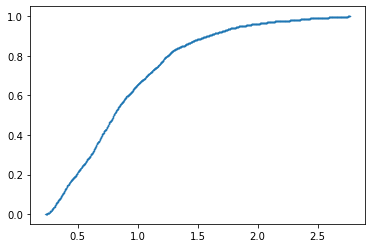

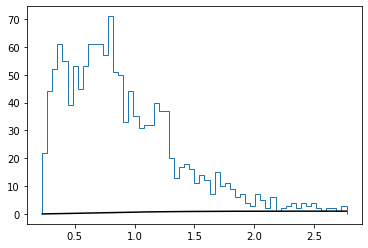

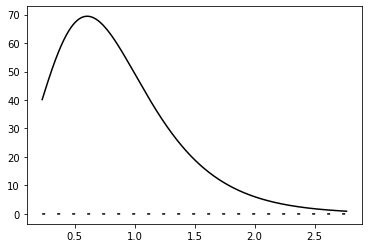

In [3]:
#reading in data
perc = 0.2
file = 'hh_div/regrid_hh711_ston_'+str(perc)+'.fits'
w, data = file_open(file)
               
coords_list = [[(583, 441), (36, 39)]]

for i in range(len(coords_list)):
    #unpacking coords
    position = coords_list[i][0]
    size = coords_list[i][1]

    #cutting out coordinates
    cutout = Cutout2D(data, position, size, wcs = w)
    datacut = cutout.data
    wcscut = cutout.wcs

    #     flattening data
    flat_data = datacut.flatten()
    xedf, yedf = edf_calc(flat_data)

    #restricting data range
#     idx = (xedf>0.1)*(xedf<3.5)  #returning mask for array indexing
#     yedf = yedf[idx]
#     xedf = xedf[idx]

    #plotting only a limited range of data to check
    plt.figure(111)
    #     plt.scatter(xedf[a0:af], yedf[a0:af], label =  str(i+7), s = 0.1) 
    plt.scatter(xedf, yedf, label =  'HH '+str(i+10), s = 0.1)
    
    plt.figure(112)
    n, bins, patches = plt.hist(flat_data, label = 'HH '+str(i+10), histtype ='step', density=False, bins=60)  # density=False would make counts
    print('HH 10, 60 bins, N/sqrt(N)', n[-7:] / np.sqrt(n[-7:]), 'bin loc', bins[-7:])

    a0 = int(0)
    af = -1
    popt, deriv2 = func_fitter(xedf[a0:af], yedf[a0:af], 'HH '+str(i+10), 5000, p0=[1,1,1,1,1,1], pdf_scale=np.max(n))
    zero_finder(deriv2, xedf[a0:af])
#     print('hh'+str(i+10)+' deriv2: ', deriv2)
#     print('hh'+str(i+10)+' deriv2 turnoff in x:', xedf[6570:-1])

#     print(xedf[0:af])
    kn = KneeLocator(xedf[0:af], edf_func(xedf[0:af], *popt), curve='concave', direction='increasing')
    print('hh'+str(i+10)+' knee: ', kn.knee)
    

# file = 'HH6/regrid_hub_longexp_1.26_to_1.64_0.0_ston_0.8.fits'
perc=0.2
file = 'hh_div/regrid_hh6_ston_'+str(perc)+'.fits'
w, data = file_open(file)

# coords_list = [[(50., 65.), (40, 40)], [(97, 75), (40, 40)],[(100, 119), (47, 47)],[(120, 167), (47, 47)],[(167, 115), (44, 44)],[(175, 163), (40, 40)],[(220, 167), (52, 52)],]
coords_list = [[(53, 64), (38, 35)], [(95, 72), (17, 29)],[(103, 116), (35, 34)],[(166, 111), (38, 38)],[(175, 163), (30, 29)],[(223, 165), (34, 37)],]

hh6_concat = [] #initializing list to join all the hh6 knots

for i in range(len(coords_list)):
    #unpacking coords
    position = coords_list[i][0]
    size = coords_list[i][1]

    #cutting out coordinates
    cutout = Cutout2D(data, position, size, wcs = w)
    datacut = cutout.data
    wcscut = cutout.wcs


    #     flatting data and plotting EDF
    flat_data = np.sort(datacut.flatten())
    
    #incase needing to restrict data...
    hh6_concat = np.concatenate((hh6_concat, flat_data), axis=None)


xedf, yedf = edf_calc(hh6_concat)
a0 = int(0)
af = int(6575)

plt.figure(112)
n, bins, patches = plt.hist(hh6_concat, label = 'HH 6', density=False, histtype ='step', bins=12)  # density=False would make counts
print('HH 6, 12 bins, N/sqrt(N)', n[-7:] / np.sqrt(n[-7:]), 'bin loc', bins[-7:])

popt, deriv2 = func_fitter(xedf[a0:af], yedf[a0:af], 'HH 6', 5000, p0=[1,1,1,1,1,1], pdf_scale=np.max(n))
zero_finder(deriv2, xedf[a0:af])
# print('deriv2: ', deriv2)
# print('hh 6 deriv2 turnoff in x:', xedf[6570:6573])

# print(xedf[5500:af])
kn = KneeLocator(xedf[5500:af], edf_func(xedf[5500:af], *popt), curve='concave', direction='increasing')
print('hh 6 knee: ', kn.knee)

plt.figure(111)
plt.title('EDF+fit')
plt.scatter(xedf, yedf, label = 'HH 6', s = 0.1)
plt.xlabel('1.26/1.64 Flux')
plt.ylabel('Cumulative Probability')
plt.legend(loc='best')

plt.figure(112)
plt.title('first deriv (histogram+fit)')
plt.yscale('log')
plt.ylabel('N')
plt.xlabel('1.26/1.64 Flux')
plt.legend(loc='best')

plt.figure(113)
plt.title('second deriv (just fit)')
plt.ylabel('???')
plt.xlabel('1.26/1.64 Flux')
plt.legend(loc='best')

In [4]:
#cell to regrid and convolve stuffs

#only saving the fits files
def cutout_saver(filenames, pos, size, name, save=False):
    for file in filenames:
        hdu1 = fits.open(file)  #import image
        w = wcs.WCS(hdu1[1].header)   #get wcs coords
        w_header = w.to_header()
        #     w = wcs.utils.wcs_to_celestial_frame(w)

        #cuting out data and wcs
        data = hdu1[1].data    
        cutout = Cutout2D(data, position, size, wcs = w.celestial)
        datacut = cutout.data

        #fix wcs
        wcscut = cutout.wcs #need wcs
        newhead = hdu1[0].header.update(wcscut.to_header())          #updating header with WCS info
#         w_header['CRPIX1'] = w_cut.to_header()['CRPIX1']
#         w_header['CRPIX2'] = w_cut.to_header()['CRPIX2']
        hdu1.close()

        #plotting
        implot(datacut, wcs.WCS(wcscut), False, np.mean(datacut))  

        #saving full fits file...
        if save == True:
            lamnum = file[file.index('build')-3:file.index('build')]
            fits.writeto('hh_cutouts/'+name+lamnum+".fits", datacut, wcscut.to_header(), overwrite=True)
        
        
# In[4]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


# In[5]:

'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''


def im_conv(low_res_name, D, hdu_pix_torad, hdu_dat, kern):
    #unfortuantely no good way to find wavelength from header right now. can enter it manually, but I tried to automate it

    #reading in excel file of wavelengths...right now needs to be in same directory as this code
    #first col is a substring of the fits image file name, the second col is the wavelengths in microns
    df = pd.read_excel('../imglams.xlsx')
    cols = df.columns
    cols_str = [str(i) for i in df[cols[0]]]
    #some test cases I was using

    #gaussian kernel
    if kern == 'gauss':
        #this finds the loc in the excel file where the image substring matches our image name
        #it then finds the wavelength value corresponding to that loc
        lam =  df.loc[np.where([i in low_res_name for i in cols_str])[0][0]].values[1] #lambda in microns

        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv


# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])

    #saving the file
    new_filename = name.split('/')[-1]  #grabs the file name we were using from before
    hdul.writeto(save_path+new_filename, overwrite=True)

    return (save_path+new_filename)


In [5]:
#the hubble images
files_units = ['../../ngc1333_fits/126build_shift_2_drz.fits', '../../ngc1333_fits/128build_shift_2_drz.fits', 
               '../../ngc1333_fits/164build_shift_2_drz.fits']
hdu_list = [fits.open(i) for i in files_units]
hdu_header_list = [fits.open(i)[0].header for i in files_units]

#IMPORTANT: first load in file to cutout of...
# filenames = files_units #glob.glob('../../ngc1333_fits/*drz.fits') #normally glob is convenient, but here we only doing x2
# print(filenames)

# '''
# HH 5: 7095.485, 1391.142
# '''
# position = (7095.485, 1391.142)  #x, y!
# size = (220, 220)  #y, x!...necessary b/c of how cutout works
# name = 'hh5_lam'
# cutout_saver(files_units, position, size, name, save=True)
# '''
# # HH 6: 
# # '''
# position = (4725, 2875)  #x, y!
# size = (240, 300)  #y, x!...necessary b/c of how cutout works
# name = 'hh6_lam'
# cutout_saver(files_units, position, size, name, save=True)
# '''
# HH 711: 
# '''
# position = (6124.0401,3215.233)  #x, y!
# size = (959,1054)  #y, x!...necessary b/c of how cutout works
# name = 'hh711_lam'
# cutout_saver(files_units, position, size, name, save=True)
# '''
# HH 13: 10539.368, 3924.647
# '''
# position = (10539.368, 3924.647)  #x, y!
# size = (220, 220)  #y, x!...necessary b/c of how cutout works
# name = 'hh13_lam'
# cutout_saver(files_units, position, size, name, save=True)
# '''
# HH 15: 9773.224, 2878.197
# '''
# position = (9773.224, 2878.197)  #x, y!
# size = (250, 250)  #y, x!...necessary b/c of how cutout works
# name = 'hh15_lam'
# cutout_saver(files_units, position, size, name, save=True)
# '''
# '''
# HH 16: 
# '''
# position = (9081.8719, 2105.2402)  #x, y!
# size = (70, 150)  #y, x!...necessary b/c of how cutout works
# name = 'hh16_lam'
# cutout_saver(files_units, position, size, name, save=True)
# # '''
# # HH 17: looks like a star
# # '''
# position = (4512.2483, 2073.0366)  #x, y!
# size = (250, 250)  #y, x!...necessary b/c of how cutout works
# name = 'hh17_lam'
# cutout_saver(files_units, position, size, name, save=True)
# # '''
# # '''
# # HH 18: Cutoff from image:(
# # '''
# # HH 340: 
# # '''
# position = (11240.533, 3900.8797)  #x, y!
# size = (200, 150)  #y, x!...necessary b/c of how cutout works
# name = 'hh340_lam'
# cutout_saver(files_units, position, size, name, save=True)
# # '''
# # HH 341: 9335.032, 3892.378
# # '''
# position = (9335.032, 3892.378)  #x, y!
# size = (250, 250)  #y, x!...necessary b/c of how cutout works
# name = 'hh341_lam'
# cutout_saver(files_units, position, size, name, save=True)
# # '''
# # HH 342: Cutoff by pixel:(
# # '''

#
# sys.exit()


# In[21]:

#EX: grabbing all the fits image paths in a directory, so they can be looped through and their data opened
#set your path to some directory with images (the images can be in subdirectories)
#using ** will grab all files even in subdirectories...WARNING this will take longer

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_fnu_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

#defining new list for the actual image we're using...
im_names_hh5 = ['hh_cutouts/hh5_lam126.fits', 'hh_cutouts/hh5_lam128.fits', 'hh_cutouts/hh5_lam164.fits']
im_names_hh6 = ['hh_cutouts/hh6_lam126.fits', 'hh_cutouts/hh6_lam128.fits', 'hh_cutouts/hh6_lam164.fits']
im_names_hh711 = ['hh_cutouts/hh711_lam126.fits', 'hh_cutouts/hh711_lam128.fits', 'hh_cutouts/hh711_lam164.fits']
im_names_hh13 = ['hh_cutouts/hh13_lam126.fits', 'hh_cutouts/hh13_lam128.fits', 'hh_cutouts/hh13_lam164.fits']
im_names_hh15 = ['hh_cutouts/hh15_lam126.fits', 'hh_cutouts/hh15_lam128.fits', 'hh_cutouts/hh15_lam164.fits']
im_names_hh16 = ['hh_cutouts/hh16_lam126.fits', 'hh_cutouts/hh16_lam128.fits', 'hh_cutouts/hh16_lam164.fits']
im_names_hh340 = ['hh_cutouts/hh340_lam126.fits', 'hh_cutouts/hh340_lam128.fits', 'hh_cutouts/hh340_lam164.fits']
im_names_hh341 = ['hh_cutouts/hh341_lam126.fits', 'hh_cutouts/hh341_lam128.fits', 'hh_cutouts/hh341_lam164.fits']
im_picks_list = [im_names_hh5, im_names_hh6, im_names_hh13, im_names_hh15, im_names_hh16,
                 im_names_hh340, im_names_hh341]


#looping through chosen HHs and regridding
# hdu_header1 = hdu_list[0][1].header #126
# hdu_header2 = hdu_list[2][1].header #164
# hdu_header128 = hdu_list[1][1].header #128
# w = wcs.WCS(hdu_header1)

for name, name128, name2 in im_picks_list:
    #reading in files
    hdu1 = fits.open(name) #126
    hdu_header1 = hdu1[0].header 
    hdu2 = fits.open(name2) #164
    hdu_header2 = hdu2[0].header
    hdu128 = fits.open(name128) #128
    hdu_header128 = hdu128[0].header
    w = wcs.WCS(hdu_header1)

    #reading in conversions
    hdu_pix1 = (hdu_list[0][0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
    hdu_pixtorad1 = (hdu_pix1 / 206265.)
    hdu_flam1 = (hdu_list[0][0].header['PHOTFLAM'])
    hdu_bw1 = (hdu_list[0][0].header['PHOTBW'])

    hdu_pix2 = (hdu_list[2][0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
    hdu_pixtorad2 = (hdu_pix2 / 206265.)
    hdu_flam2 = (hdu_list[2][0].header['PHOTFLAM'])
    hdu_bw2 = (hdu_list[2][0].header['PHOTBW'])
    
    hdu_pix128 = (hdu_list[1][0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
    hdu_pixtorad128 = (hdu_pix128 / 206265.)
    hdu_flam128 = (hdu_list[1][0].header['PHOTFLAM'])
    hdu_bw128 = (hdu_list[1][0].header['PHOTBW'])

    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu1_data = hdu1[0].data * hdu_flam1 * hdu_bw1
    hdu2_data = hdu2[0].data * hdu_flam2 * hdu_bw2
    hdu128_data = hdu128[0].data * hdu_flam128 * hdu_bw128

    
               
               
    
    #convolving images
    D = 2.4 #that of Hubble, in m
    D *= 1e6 #converting to microns since x m / 1 m * 1E6 microns gets microns, the unit of our wavelength file
    
    hdu1_conv = im_conv(name, D, hdu_pixtorad1, hdu1_data, 'gauss')
    hdu1_conv = im_conv(name, D, hdu_pixtorad2, hdu1_conv, 'gauss')
    hdu2_conv = im_conv(name2, D, hdu_pixtorad2, hdu2_data, 'gauss')
    hdu2_conv = im_conv(name2, D, hdu_pixtorad1, hdu2_conv, 'gauss')
    hdu128_conv = im_conv(name128, D, hdu_pixtorad128, hdu128_data, 'gauss')
    hdu128_conv = im_conv(name128, D, hdu_pixtorad2, hdu128_conv, 'gauss')   

    #converting the convolved image to correct units and saving it so we can reproject it
    #conversion needed for hubble case since units are not in terms of surface brightness
#     hdu1_conv_scaled = hdu1_conv   #dividing out sr, D001SCAL is key for pixel size in arcsec
    hdu2_conv_scaled = hdu2_conv  / hdu_pixtorad2**2. #dividing out sr, D001SCAL is key for pixel size in arcsec
    hdu128_conv_scaled = hdu128_conv  / hdu_pixtorad128**2.
    
    #you'll need to set the WCS to be that of the header you're basing this off of...ie the header
    file_start = '../Convolved_Images_Hub/conv_'
    conv1_path = fits_saver(hdu1_conv, hdu_header1, name, file_start)
    conv2_path = fits_saver(hdu2_conv_scaled, hdu_header2, name2, file_start)
    conv128_path = fits_saver(hdu128_conv_scaled, hdu_header128, name128, file_start)
    
    
    
    
    
    #reprojection of one hdu using the header (coords and pixels) of another
    #The first input is the path to the file we're reprojecting. The second input is the header of the image we're projecting ONTO
    #para is False for large images (like these hubble ones)
    #output is array (a 2D array of data) and footprint (the footprint from the analysis)
    para = False
    array, footprint = reproject_exact(conv2_path, w, shape_out=hdu1_conv.shape, parallel=para)
    array_128, footprint_128 = reproject_exact(conv128_path, w, shape_out=hdu1_conv.shape, parallel=para)

    file_start = '../Regridded_Hub/regrid_'
    regrid_2_path = fits_saver(array * hdu_pixtorad1**2., hdu_header1, name2, file_start)
    regrid_2_foot_path = fits_saver(footprint * hdu_pixtorad1**2., hdu_header1, name2, file_start+'footprint_')
    
    regrid_128_path = fits_saver(array_128 * hdu_pixtorad1**2., hdu_header1, name128, file_start)
    regrid_128_foot_path = fits_saver(footprint_128* hdu_pixtorad1**2., hdu_header1, name128, file_start+'footprint_')

     
    
    
    # In[21]:
    #declaring noise: measured from the RMS of a region of empty sky while opening the image in DS9
    #these are newly taken from the HH 6 images...
    noise_126 = 7e-18 #0.0465246*1e-16
    noise_128 = 7e-18 #0.05*1e-16
    noise_164 = 7e-18 #0.0561296*1e-16

    #now that we have a reprojected hubble image for hdu2 and both are convolved, need to
    #divide one by the other...then can use the same wcs header that we projected onto (hdu1's)!

    #the signal to noise cutoff? can try with and without
    flux01 = hdu1_conv
    flux02 = array * hdu_pixtorad1**2.
    flux_128 = array_128 * hdu_pixtorad1**2.
    
    perc = 0.2 #this tends to work?? Maybe can change...
    flux01[flux01/noise_126 < perc] = np.nan   
    flux02[flux02/noise_164 < perc] = np.nan
    flux_128[flux_128/noise_128 < perc] = np.nan
#     flux01[flux01 <= noise_126] = np.nan   
#     flux02[flux02 <= noise_164] = np.nan
#     flux_128[flux_128 <= noise_128] = np.nan
    
    
    #saving just each separate image with the noise filter on
    save_path = 'hh_filtered/'
    fits_saver(flux01, hdu_header1, name.split('/')[1].split('_')[0]+'_126_ston_'+str(perc)+'.fits', save_path)
    fits_saver(flux02, hdu_header1, name.split('/')[1].split('_')[0]+'_164_ston_'+str(perc)+'.fits', save_path)
    fits_saver(flux_128, hdu_header1, name.split('/')[1].split('_')[0]+'_128_ston_'+str(perc)+'.fits', save_path)

    # remember to have the right header with the wcs below and that it matches the one we're projecting ONTO
    print(name.split('/')[1].split('_')[0]+'_ratio126to164_ston_'+str(perc)+'.txt')
    
    data_ratio = np.divide(flux01, flux02, out=np.zeros_like(flux02), where=flux02!=0.) #need to do np.divide to guarantee we get no divide by zero issue...
    save_path = 'hh_div_moreratios/'  #See fits_saver's "save_path" description for explanation
    fits_saver(data_ratio, hdu_header1, name.split('/')[1].split('_')[0]+'_ratio126to164_ston_'+str(perc)+'.fits', save_path)  #saving the reprojected image
    placeholder = np.savetxt(save_path + name.split('/')[1].split('_')[0]+'_ratio126to164_ston_'+str(perc)+'.txt', data_ratio)
    
    #now trying 1.64/pabeta aka 1.28
    data_ratio_speed = np.divide(flux02, flux_128, out=np.zeros_like(flux_128), where=flux_128!=0.) #need to do np.divide to guarantee we get no divide by zero issue...
    fits_saver(data_ratio_speed, hdu_header1, name.split('/')[1].split('_')[0]+'_ratio164to128_ston_'+str(perc)+'.fits', save_path)  #saving the reprojected image
    placeholder = np.savetxt(save_path + name.split('/')[1].split('_')[0]+'_ratio164to128_ston_'+str(perc)+'.txt', data_ratio_speed)

    


    
#specifically for HH 7_11
hh711_path = '../../ngc1333_fits/Background_corr/'
hdu1_hh711 = fits.open(hh711_path + 'background_corr_' + '126' + '_aligned.fits')
hdu128_hh711 = fits.open(hh711_path + 'background_corr_' + '128' + '_aligned.fits')
hdu2_hh711 = fits.open(hh711_path + 'background_corr_' + '164' + '_aligned.fits')

#reading in conversions
hdu_pix1 = (hdu_list[0][0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
hdu_pixtorad1 = (hdu_pix1 / 206265.)

hdu_pix2 = (hdu_list[1][0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
hdu_pixtorad2 = (hdu_pix2 / 206265.)
    
hdu_pix128 = (hdu_list[1][0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
hdu_pixtorad128 = (hdu_pix128 / 206265.)
    
#reading in data for general use  and header for wcs, background corrected
hdu1_data = hdu1_hh711[0].data 
hdu2_data = hdu2_hh711[0].data 
hdu128_data = hdu128_hh711[0].data
#converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above



#first convolve (already regridded)
D = 2.4 #that of Hubble, in m
D *= 1e6 #converting to microns since x m / 1 m * 1E6 microns gets microns, the unit of our wavelength file

hdu1_conv = im_conv('background_corr_' + '126' + '_aligned.fits', D, hdu_pixtorad1, hdu1_data, 'gauss')
hdu1_conv = im_conv('background_corr_' + '126' + '_aligned.fits', D, hdu_pixtorad2, hdu1_conv, 'gauss')
hdu2_conv = im_conv('background_corr_' + '164' + '_aligned.fits', D, hdu_pixtorad2, hdu2_data, 'gauss')
hdu2_conv = im_conv('background_corr_' + '164' + '_aligned.fits', D, hdu_pixtorad1, hdu2_conv, 'gauss')
hdu128_conv = im_conv('background_corr_' + '128' + '_aligned.fits', D, hdu_pixtorad128, hdu128_data, 'gauss')
hdu128_conv = im_conv('background_corr_' + '128' + '_aligned.fits', D, hdu_pixtorad2, hdu128_conv, 'gauss')   

#now divide and filter...
perc = 0.8 #this tends to work?? Maybe can change...
noise_126 = 2.6e-18
noise_128 = 3e-18
noise_164 = 5.766e-18
# hdu1_conv[hdu1_conv/noise_126 < perc] = np.nan   
# hdu2_conv[hdu2_conv/noise_164 < perc] = np.nan
hdu1_conv[hdu1_conv <= 5e-18] = np.nan 
hdu2_conv[hdu2_conv <= 5e-18] = np.nan
hdu128_conv[hdu128_conv <= 5e-18] = np.nan



# remember to have the right header with the wcs below and that it matches the one we're projecting ONTO
hdu_header1 = hdu1_hh711[0].header

#saving the noise filtered images for hh 7-11
save_path = 'hh_filtered/'
# fits_saver(hdu1_conv, hdu_header1, name.split('/')[1].split('_')[0]+'_126_ston_'+str(perc)+'.fits', save_path)
# fits_saver(hdu2_conv, hdu_header1, name.split('/')[1].split('_')[0]+'_164_ston_'+str(perc)+'.fits', save_path)

#saving the divided image
save_path = 'hh_div_moreratios/'  #See fits_saver's "save_path" description for explanation

data_ratio = np.divide(hdu1_conv, hdu2_conv, out=np.zeros_like(hdu2_conv), where=hdu2_conv!=0.) #need to do np.divide to guarantee we get no divide by zero issue...
# save_path = 'hh_div/conv_'  #See fits_saver's "save_path" description for explanation
# fits_saver(data_ratio, hdu_header1, 'hh711_'+'_ston_'+str(perc)+'.fits', save_path)  #saving the reprojected image
fits_saver(data_ratio, hdu_header1, 'hh711_ratio126to164_ston_'+str(perc)+'.fits', save_path)  #saving the reprojected image
placeholder = np.savetxt(save_path + 'hh711_ratio126to164_ston_'+str(perc)+'.txt', data_ratio)

#now trying 1.64/pabeta aka 1.28
data_ratio_speed = np.divide(hdu2_conv, hdu128_conv, out=np.zeros_like(hdu128_conv), where=hdu128_conv!=0.) #need to do np.divide to guarantee we get no divide by zero issue...
fits_saver(data_ratio_speed, hdu_header1, 'hh711_ratio164to128_ston_'+str(perc)+'.fits', save_path)  #saving the reprojected image
placeholder = np.savetxt(save_path + 'hh711_ratio164to128_ston_'+str(perc)+'.txt', data_ratio_speed)
    




    

<ipython-input-2-08e2e603a34e>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


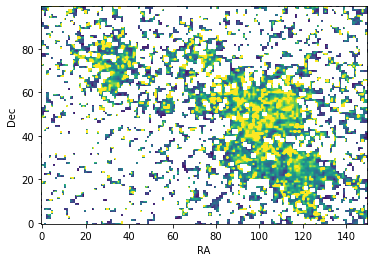

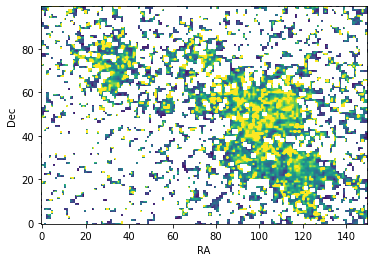

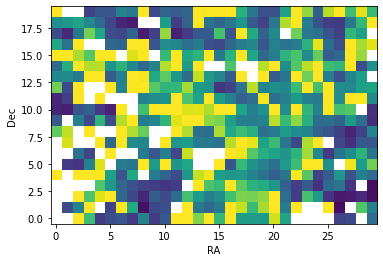

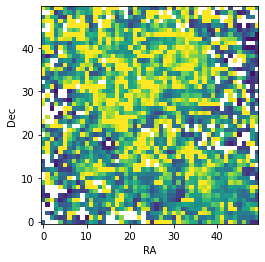

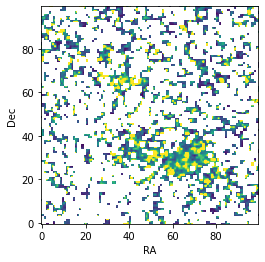

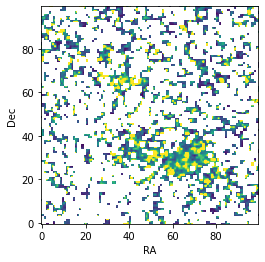

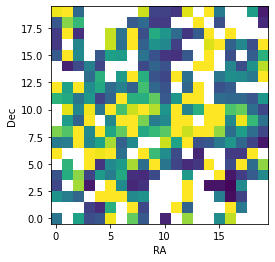

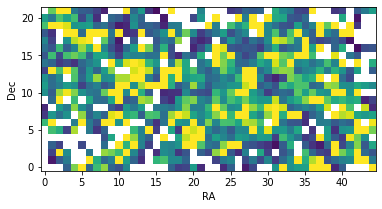

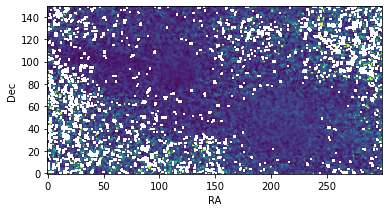

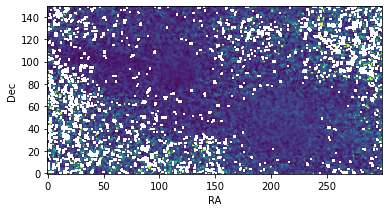

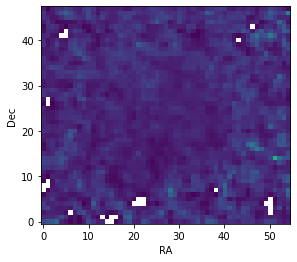

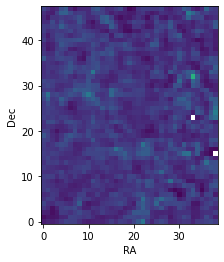

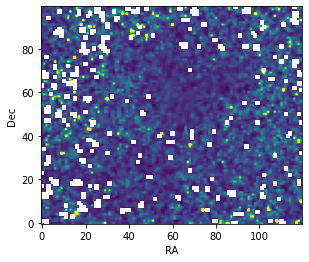

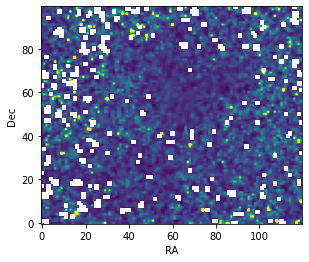

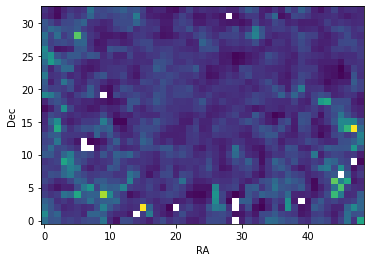

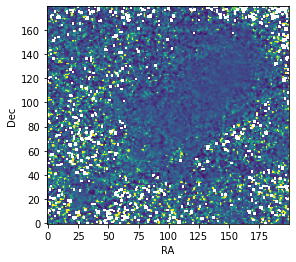

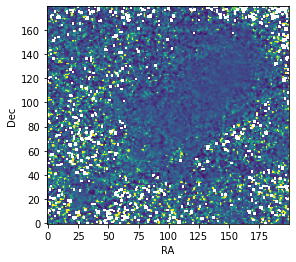

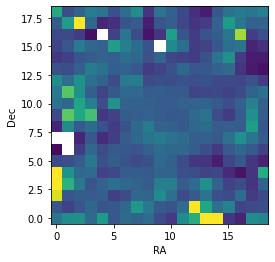

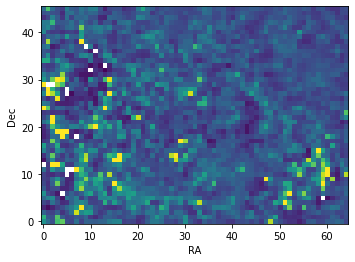

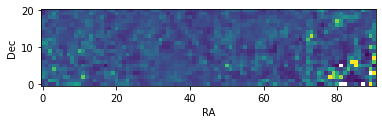

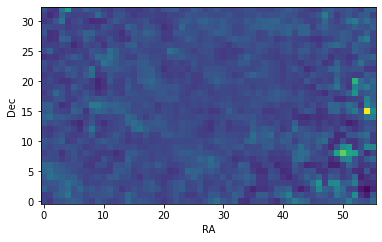

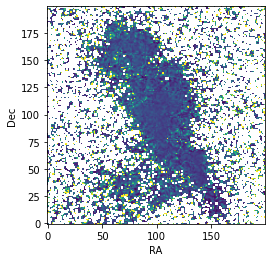

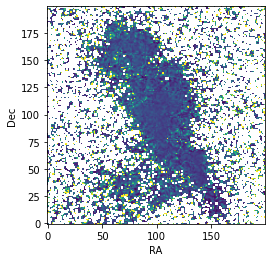

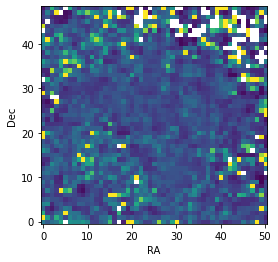

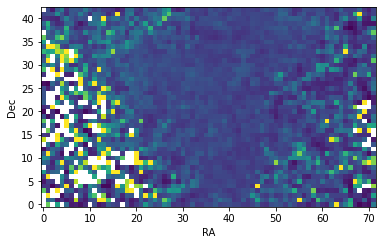

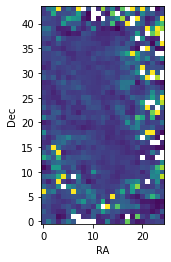

In [5]:
#I just make a separate file with images of the 1.26 to 1.64 ratio
# file = '../../Convolved_Images_Hub/conv_126_image.fits'
# file = 'regrid_hub_dash_noleakage_ston_0.8.fits'  #this was the one I used before...
path = 'southernoutflows_amanda/Frame3-selected/'
# file = path+'regrid_lamflam_126_dash_filled_final.fits' # AB: either 126_ or 164_
filelist = [path+'regrid_lamflam_126_dash_filled_final.fits', 
            path+'regrid_lamflam_128_dash_filled_final.fits',
            path+'regrid_lamflam_164_dash_filled_final.fits']


# for file in filelist:
#     hdu1 = fits.open(file)        #import image
#     w = wcs.WCS(hdu1[0].header)   #get wcs coords
#     data = hdu1[0].data           #get data from hdu
#     #hdu1.close()                  #closing just in case? # AB: moved the location of the close

#     #plotting to review what data looks like, need to send wcs regardless
#     #probably need to make wcs an optional param...
#     implot(data, w, False, 0.3)  # AB: change the last number value so plot was easier to see

#     #initial guesses for cutout coords of scattered(?) light
#     #guessing 
#     # AB: updated to values for lower region
#     coords_list = [[(1995-6, 1460+1), (100, 150)],
#                   [(2120-6, 1371+1), (100, 100)],
#                   [(1200-6, 2000+1), (150, 300)], 
#                   [(1480-6, 1950+1), (100,120)],
#                   [(2010-6, 1920+1), (180, 200)],
#                   [(2480-6, 1960+1), (200, 200)],
#                   ]

#     #plotting cutouts, probably better loops for this
#     for i in range(len(coords_list)):
#         #unpacking coords
#         position = coords_list[i][0]
#         size = coords_list[i][1]

#         #cutting out coordinates using Cutout2D
#         cutout = Cutout2D(data, position, size, wcs = w)
#         datacut = cutout.data
#         wcscut = cutout.wcs

#         #plotting *cutout*
#         implot(datacut, wcscut, False, 0.3) 
#         #plt.savefig('knot'+str(i+1)) #+6 b/c of indexing, would have to adjust that and path

#         # AB: add on to try and save the cutouts as a fits file to do the division
#         hdu1[0].data = datacut
#         hdu1[0].header.update(wcscut.to_header())
#         hdu1[0].writeto('hh_cutouts/amanda_'+file.split('_')[-4]+'_knot'+str(i+1)+'_shift.fits', overwrite=True)

#     hdu1.close()


# creating the 126/164 ratio for each of the cutouts and saving that value to fits file
# written mostly on my own, probaly missing some stuff

noise_126 = 2.64e-18
noise_128 = 3e-18 # 0.0290156*1e-16
noise_164 = 3.335e-18

im126 = fits.open(path+'regrid_lamflam_126_dash_filled_final.fits')
# hdu_126_flam = im126[0].header['PHOTFLAM']
# hdu_126_bw = im126[0].header['PHOTBW']

im128 = fits.open(path+'regrid_lamflam_128_dash_filled_final.fits')

im164 = fits.open(path+'regrid_lamflam_164_dash_filled_final.fits')
# hdu_164_flam = im164[0].header['PHOTFLAM']
# hdu_164_bw = im164[0].header['PHOTBW']

coords_list =  [
                [[(30, 72), (20, 30)], [(105, 42), (50, 50)]],
                [[(40, 66), (20, 20)], [(61, 30), (22, 45)]],
                [[(118, 91), (48, 55)], [(232, 50), (48, 39)]],
                [[(64, 55), (33, 49)]],
                [[(27, 21), (19, 19)], [(83, 70), (46, 65)],[(118, 85), (21, 91)], [(148, 120), (33, 56)]],
                [[(78, 161), (49, 51)], [(100, 95), (43, 72)], [(139, 50), (44, 25)]]
                    ]

count = 0
knots = [1,2,3,4,5,6]
for i in range(len(knots)):
    im_126cut = 'hh_cutouts/amanda_126_knot'+str(knots[i])+'_shift.fits'
    im_128cut = 'hh_cutouts/amanda_128_knot'+str(knots[i])+'_shift.fits'
    im_164cut = 'hh_cutouts/amanda_164_knot'+str(knots[i])+'_shift.fits'

    hdu_126 = fits.open(im_126cut)
    hdu_126_data = hdu_126[0].data
    #hdu_126_data = hdu_126[1].data * hdu_126_flam * hdu_126_bw
    wcs_126 = wcs.WCS(hdu_126[0].header)
    #noise_126 = noise_126 * hdu_126_flam * hdu_126_bw
    
    hdu_128 = fits.open(im_128cut)
    hdu_128_data = hdu_128[0].data
    #hdu_128_data = hdu_128[1].data * hdu_128_flam * hdu_128_bw
    wcs_128 = wcs.WCS(hdu_128[0].header)
    #noise_128 = noise_128 * hdu_128_flam * hdu_128_bw

    hdu_164 = fits.open(im_164cut)
    hdu_164_data = hdu_164[0].data
    #hdu_164_data = hdu_164[1].data * hdu_164_flam * hdu_164_bw
    #noise_164 = noise_164 * hdu_164_flam * hdu_164_bw
    
    perc = 0.1 #this tends to work?? Maybe can change...
    hdu_126_data[hdu_126_data < noise_126*perc] = np.nan  
    hdu_128_data[hdu_128_data < noise_128*perc] = np.nan  
    hdu_164_data[hdu_164_data < noise_164*perc] = np.nan

    data_ratio = np.divide(hdu_126_data, hdu_164_data, out=np.zeros_like(hdu_164_data), where=hdu_164_data!=0.)
    #plt.imshow(data_ratio, vmin = 0, vmax = 1)
    implot(data_ratio, wcs_126, wcscond=False, vmax_p=2) 

    hdu_126[0].data = data_ratio
    #hdu_126[0].header.update(wcscut.to_header())
    hdu_126[0].writeto('hh_div_moreratios/amanda_126to164ratio_knot'+str(i+1)+'.fits', overwrite=True)
    placeholder = np.savetxt('hh_div_moreratios/amanda_126to164ratio_knot'+str(i+1)+'.txt', data_ratio)
    
    data_ratio_speed = np.divide(hdu_164_data, hdu_128_data, out=np.zeros_like(hdu_128_data), where=hdu_128_data!=0.)
    #plt.imshow(data_ratio, vmin = 0, vmax = 1)
    implot(data_ratio, wcs_126, wcscond=False, vmax_p=2) 

    hdu_126[0].data = data_ratio_speed
    #hdu_126[0].header.update(wcscut.to_header())
    hdu_126[0].writeto('hh_div_moreratios/amanda_164to128ratio_knot'+str(i+1)+'.fits', overwrite=True)
    placeholder = np.savetxt('hh_div_moreratios/amanda_164to128ratio_knot'+str(i+1)+'.txt', data_ratio_speed)

    

    #plotting test cutouts...
    for j in coords_list[count]:        
        #unpacking coords
        position = j[0]
        size = j[1]

        #cutting out coordinates
        cutout = Cutout2D(data_ratio, position, size, wcs = wcs_126)
        datacut = cutout.data
        wcscut = cutout.wcs
        
        #plotting
        implot(datacut, wcs_126, wcscond=False, vmax_p=2) 
    count+=1

In [ ]:
#need to set up figures...
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,15), sharex=True, constrained_layout=True)
# fig.suptitle('Fe[II] Line Ratios of Herbig-Haro Objects')


#plot formatting
#from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
ax1.tick_params(axis='both', which='major', width=3)
ax1.tick_params(axis='both', which='minor', width=2)
ax2.tick_params(axis='both', which='major', width=3)
ax2.tick_params(axis='both', which='minor', width=2)


from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['green', 'black', 'gray', 'blue', 'brown', 'chocolate', 'salmon',
                                           'darkorange', 'gold', 'khaki', 'teal', 'powderblue', 'steelblue',
                                           'darkviolet', 'plum', 'magenta', 'deeppink', 'pink'])))





# file = 'HH6/regrid_hub_longexp_1.26_to_1.64_0.0_ston_0.8.fits'
perc=0.2
file = 'hh_div/regrid_hh6_ston_'+str(perc)+'.fits'
w, data = file_open(file)

# coords_list = [[(50., 65.), (40, 40)], [(97, 75), (40, 40)],[(100, 119), (47, 47)],[(120, 167), (47, 47)],[(167, 115), (44, 44)],[(175, 163), (40, 40)],[(220, 167), (52, 52)],]
coords_list = [[(53, 64), (38, 35)], 
               [(95, 72), (17, 29)],
               [(103, 116), (35, 34)],
               [(166, 111), (38, 38)],
               [(175, 163), (30, 29)],
               [(223, 165), (34, 37)],]

hh6_concat = [] #initializing list to join all the hh6 knots

for i in range(len(coords_list)):
    #unpacking coords
    position = coords_list[i][0]
    size = coords_list[i][1]

    #cutting out coordinates
    cutout = Cutout2D(data, position, size, wcs = w)
    datacut = cutout.data
    wcscut = cutout.wcs


    #     flatting data and plotting EDF
    flat_data = np.sort(datacut.flatten())
    
    #incase needing to restrict data...
    a0 = int(1.4e3)
    af = int(1e6)
    hh6_concat = np.concatenate((hh6_concat, flat_data), axis=None)

xedf, yedf = edf_calc(hh6_concat)
# plt.figure(111)
plot_color = ax1.plot(xedf, yedf, label =  'HH 6', linewidth = 3.5, linestyle='-')
# print(plot_color.get_facecolor())




#reading in data
# file = 'HH7_11/1.26_to_1.64_hub_dash_noleakage_ston_0.8.fits'  #reading in file
# file = 'HH7_11/nonlintest_hub_dash_noleakage_ston_-1.fits'
# file = 'hh_div/conv_'+'background_corr_hh711_'+'_ston_'+str(perc)+'.fits'
perc = 0.2
file = 'hh_div/regrid_hh711_ston_'+str(perc)+'.fits'
w, data = file_open(file)


#coords from above...
# coords_list = [#[(550, 170), (100, 200)], 
#                [(586, 357), (80, 60)], 
#                [(467, 395), (40, 40)], 
#                [(590, 450), (40, 40)], 
#                [(550, 525), (40,40)]
#                 ]
coords_list = [#[(550, 170), (100, 200)], 
               [(618, 345), (48, 45)], 
               [(500, 365), (40, 40)], #[(467, 395), (40, 40)], 
               [(583, 441), (36, 39)], 
               [(550, 528), (37,37)]
                ]

hh711_plotcolors = []
for i in range(len(coords_list)):
    #unpacking coords
    position = coords_list[i][0]
    size = coords_list[i][1]

    #cutting out coordinates
    cutout = Cutout2D(data, position, size, wcs = w)
    datacut = cutout.data
    wcscut = cutout.wcs

    #     flattening data
    flat_data = datacut.flatten()
    xedf, yedf = edf_calc(flat_data)

    #restricting data range
    idx = (xedf>0.1)*(xedf<3.5)  #returning mask for array indexing
    yedf = yedf[idx]
    xedf = xedf[idx]

    #plotting only a limited range of data to check
#     plt.figure(111)
    #     plt.scatter(xedf[a0:af], yedf[a0:af], label =  str(i+7), s = 0.1) 
    if i+8 == 10:
        l_size = 3.5
        l_style = '-'
    else:
        l_size = 1
        l_style = '--'
    
    plot_color = ax1.plot(xedf, yedf, label =  'HH '+str(i+8), linewidth=l_size, linestyle=l_style)

    
'''
# coords_list =  [[(563.5, 629.5), (39, 51)],  [(504.5, 578.5), (61, 53)]] #two boxes near hh 11
coords_list = [[(849.99, 356.8), (434.4, 700.4)]] #noise box to right side of 7-11
# coords_list = [[(431.8, 359.2), (228, 68.4)]] #1 box to the side of hh 9
# coords_list = [[(680.2, 548.2), (171.6, 121.2)]] #1 box above hh 8, to left of hh 10/11

flat_data = []
scatt_light_concat = []

for i in range(len(coords_list)):
    #unpacking coords
    position = coords_list[i][0]
    size = coords_list[i][1]

    #cutting out coordinates
    cutout = Cutout2D(data, position, size, wcs = w)
    datacut = cutout.data
    wcscut = cutout.wcs


    #     flatting data and plotting EDF
    flat_data = np.sort(datacut.flatten())
    
    #incase needing to restrict data...
    scatt_light_concat = np.concatenate((scatt_light_concat, flat_data), axis=None)

implot(datacut, wcscut, False, 1) 

xedf, yedf = edf_calc(scatt_light_concat)
# plt.figure(111)
plot_color = ax1.plot(xedf, yedf, label =  'HH 11 Scattered Light', linewidth = 1, linestyle='-')
# print(plot_color.get_facecolor())
'''


# filenames = glob.glob('ngc1333/hh_div/*')
filenames = glob.glob('hh_div/regrid*'+str(perc)+'*.fits')
filenames.remove('hh_div\\regrid_hh6_ston_'+str(perc)+'.fits')
filenames.remove('hh_div\\regrid_hh711_ston_'+str(perc)+'.fits')
# file = 'regrid_hub_dash_noleakage_ston_0.8.fits'

# hh13, hh15 , hh16, hh340, hh341 , hh5
coords_list =  [
              [[(90, 90), (100, 40)], [(125, 75), (70, 30)]],
              [[(100, 100), (125, 170)]],
                    [[]],
                [[]],
              [[(150, 150), (100, 50)]],
                [[(105, 95), (80, 80)], [(80, 155), (80, 50)]]
                    ]

count = 0
for file in filenames:    
    w, data = file_open(file)  
    #plotting
#     implot(data, w, False, 3) 
    
    hh_concat = [] #initializing list to join all the hh6 knots
    
    #flattening and sorting data
    if file == 'hh_div\\regrid_hh16_ston_0.2.fits' or file == 'hh_div\\regrid_hh340_ston_0.2.fits':
        hh_concat = np.sort(datacut.flatten())
    else: 
        for i in coords_list[count]:        
            #unpacking coords
            position = i[0]
            size = i[1]

            #cutting out coordinates
            cutout = Cutout2D(data, position, size, wcs = w)
            datacut = cutout.data
            wcscut = cutout.wcs

            #     flatting data and plotting EDF
            flat_data = np.sort(datacut.flatten())
            hh_concat = np.concatenate((hh_concat, flat_data), axis=None)
    
    #flattened and sorted data can now be turned into EDFs!
    xedf, yedf = edf_calc(hh_concat)

#     plt.figure(111)
#     plt.scatter(xedf[a0:af], yedf[a0:af], label = file.split("_")[2], s = 0.1)
#     plt.scatter(xedf[int(1e2):], yedf[int(1e2):], label = file.split("_")[2], s = 0.1)
#     print(file, len(xedf), len(yedf))
#     ax1.scatter(xedf, yedf, label = file.split("_")[2].replace('hh', 'hh ').upper(), s=0.1)
    ax1.plot(xedf, yedf, label = file.split("_")[2].replace('hh', 'hh ').upper(), linestyle='--')

    count += 1

    
#now doing amanda's knots (the souther outflows)
filenames = glob.glob('hh_div/*amanda*.fits')
filenames = ['hh_div_moreratios/amanda_126to164ratio_knot1.fits', 'hh_div_moreratios/amanda_126to164ratio_knot2.fits', 
             'hh_div_moreratios/amanda_126to164ratio_knot4.fits', 'hh_div_moreratios/amanda_126to164ratio_knot3.fits', 
             'hh_div_moreratios/amanda_126to164ratio_knot5.fits', 'hh_div_moreratios/amanda_126to164ratio_knot6.fits']

coords_list =  [
#                 [[(30, 72), (20, 30)], [(105, 42), (50, 50)]],
                [[(30, 71), (20, 16)], [(105, 49), (24, 27)], [(119, 26), (15, 12)]],
#                 [[(40, 66), (20, 20)], [(61, 30), (22, 45)]],
                [[(38, 67), (24, 11)], [(70, 32), (23, 20)]],
                [[(64, 55), (33, 49)]],            
                [[(118, 91), (48, 55)], [(232, 50), (48, 39)]],
                [[(27, 21), (19, 19)], [(83, 70), (46, 65)],[(118, 85), (21, 91)], [(148, 120), (33, 56)]],
                [[(78, 161), (49, 51)], [(100, 95), (43, 72)], [(139, 50), (44, 25)]]
                    ]


names_list = ['SVS 13B - HH A', 'SVS 13B - HH B', 'HH 344', 'SVS 13B - HH C', 'SVS 13B - HH D', 'SVS 13B - HH E1']

count = 0
for file in filenames:    
    w, data = file_open(file)  
    #plotting
#     implot(data, w, False, 3) 
    
    hh_concat = [] #initializing list to join all the hh6 knots
    if count > 1:
        for i in coords_list[count]:        
            #unpacking coords
            position = i[0]
            size = i[1]

            #cutting out coordinates
            cutout = Cutout2D(data, position, size, wcs = w)
            datacut = cutout.data
            wcscut = cutout.wcs

            #     flatting data and plotting EDF
            flat_data = np.sort(datacut.flatten())
            hh_concat = np.concatenate((hh_concat, flat_data), axis=None)

        #flattened and sorted data can now be turned into EDFs!
        xedf, yedf = edf_calc(hh_concat)
#         ax1.scatter(xedf, yedf, label = 'SVS 13B - HH '+file.split("_")[-1][4:-5], s=0.1)
        ax1.plot(xedf, yedf, label = names_list[count], linestyle='--')
    count += 1




# plt.figure(111)
# ax1.plot([2.6, 2.6], [0,1.1], label ='x=2.6 (This Work)', linestyle=':')
# ax1.plot([1.25, 1.25], [0,1.1], label ='x=1.25 (Bautista+2015)', linestyle=':')
# ax1.plot([2.39, 2.39], [0,1.1], label ='x=2.39 Quinet96corr', linestyle=':')
# ax1.plot([3.85, 3.85], [0,1.1], label ='x=3.85 (Nahar95, CHIANTI)', linestyle=':')
# ax1.set_ylim(0.0, 1.01)
# ax1.set_xlim(0, 4)
# plt.ylim(0.8, 1.01) #alt lims
# plt.xlim(0.5, 4)
# ax1.set_title('EDFs')
# ax1.set_xlabel('x [1.26/1.64 Flux]')
ax1.set_ylabel('Cumulative Probability')

#need to reorder legend *because of literally one thing*
handles, labels = ax1.get_legend_handles_labels()
ind_reorder = labels.index('HH 5')
handles.insert(0, handles[ind_reorder])
labels.insert(0, labels[ind_reorder])
handles.pop(labels.index('HH 5', 1))
labels.pop(labels.index('HH 5', 1))
ax1.legend(handles, labels, loc='best', markerscale = 20, ncol=2)

# plt.savefig('EDFs/EDFMAKER_otherEDF.png')





#next part: EDF fitting / histograms'
#establishing reference lines from literature
ax2.plot([2.6, 2.6], [0,1e3], label ='This Work (2.6)', color='black', linestyle='-', linewidth=3)
ax2.plot([0.69, 0.69], [0,1e3], color='black', linestyle=':') 
ax2.plot([1.03, 1.03], [0,1e3], color='black', linestyle=':') 
ax2.plot([1.04, 1.04], [0,1e3], color='black', linestyle=':') 
ax2.plot([1.17, 1.17], [0,1e3], color='black', linestyle=':') 
# ax2.plot([1.25, 1.25], [0,1e3], label ='Recommended Literature Values', color='black', linestyle=':', linewidth=3) #bautista (2015) rec
ax2.plot([1.25, 1.25], [0,1e3], color='black', linestyle=':') #bautista (2015) rec
ax2.plot([1.18, 1.18], [0,1e3], label ='Literature Values', color='black', linestyle=':')
ax2.plot([1.26, 1.26], [0,1e3], color='black', linestyle=':') 
ax2.plot([1.32, 1.32], [0,1e3], color='black', linestyle=':') #bautista et al 2017
# ax2.plot([1.36, 1.36], [0,1e3], color='black', linestyle=':', linewidth=3) #debb hibbert rec & Nussbaumer storey 1988
ax2.plot([1.36, 1.36], [0,1e3], color='black', linestyle=':') #debb hibbert rec & Nussbaumer storey 1988
ax2.plot([1.50, 1.50], [0,1e3], color='black', linestyle=':') 
ax2.plot([1.96, 1.96], [0, 1e3], color='black', linestyle=':') #Tayal & Zatsarinni 2018
ax2.plot([2.39, 2.39], [0,1e3], color='black', linestyle=':') 
ax2.plot([3.8, 3.8], [0,1e3], color='black', linestyle=':')
# ax2.plot([1.18, 1.18], [0,1e3], label ='1.18 Quinet et al. 1996 HFR', color='black', linestyle='--')
# ax2.plot([1.25, 1.25], [0,1e3], label ='1.25 Bautista et al. 2015', color='black', linestyle= (0, (5, 10))) #looseley dashed
# ax2.plot([1.36, 1.36], [0,1e3], label ='1.36 Debb & Hibbert 2011', color='black', linestyle=':')
# ax2.plot([2.39, 2.39], [0,1e3], label ='2.39 Bautista et al. 2015 & Quinet et al. 1996', color='black', linestyle=(0, (1, 10))) #looseley dotted
# ax2.plot([3.85, 3.85], [0,1e3], label ='3.85 Nahar 1995', color='black', linestyle='-.')




perc=0.2
file = 'hh_div/regrid_hh6_ston_'+str(perc)+'.fits'
w, data = file_open(file)
coords_list = [[(53, 64), (38, 35)], [(95, 72), (17, 29)],[(103, 116), (35, 34)],[(166, 111), (38, 38)],[(175, 163), (30, 29)],[(223, 165), (34, 37)],]
hh6_concat = [] #initializing list to join all the hh6 knots

for i in range(len(coords_list)):
    #unpacking coords
    position = coords_list[i][0]
    size = coords_list[i][1]

    #cutting out coordinates
    cutout = Cutout2D(data, position, size, wcs = w)
    datacut = cutout.data
    wcscut = cutout.wcs


    #     flatting data
    flat_data = np.sort(datacut.flatten())
    
    #incase needing to restrict data...
    hh6_concat = np.concatenate((hh6_concat, flat_data), axis=None)


xedf, yedf = edf_calc(hh6_concat)
a0 = int(0)
af = int(6575)

# plt.figure(113)
n, bins, patches = ax2.hist(hh6_concat, label = 'HH 6', density=False, histtype ='step', bins=50, linewidth=2, color='green')  # density=False would make counts
print('hh6, 12 bins, N/sqrt(N)', n[-15:] / np.sqrt(n[-15:]), 'bin loc', bins[-15:])
print(bins[0:-13], len(bins), len(n))
print('fraction of total counts for hh6 @ 2.6', np.sum(n[0:-13]) / np.sum(n))


#reading in data
perc = 0.2
file = 'hh_div/regrid_hh711_ston_'+str(perc)+'.fits'
w, data = file_open(file)
               
coords_list = [[(583, 441), (36, 39)]]

for i in range(len(coords_list)):
    #unpacking coords
    position = coords_list[i][0]
    size = coords_list[i][1]

    #cutting out coordinates
    cutout = Cutout2D(data, position, size, wcs = w)
    datacut = cutout.data
    wcscut = cutout.wcs

    #     flattening data
    flat_data = datacut.flatten()
    xedf, yedf = edf_calc(flat_data)

    #plotting only a limited range of data to check
#     plt.figure(112)
#     plt.scatter(xedf, yedf, label =  'hh'+str(i+10), s = 0.1)
    
#     plt.figure(113)
    n, bins, patches = ax2.hist(flat_data, label = 'HH '+str(i+10), histtype ='step', density=False, bins=50, linewidth=2, color='blue')  # density=False would make counts
    print('hh10, 60 bins, N/sqrt(N)', n[-7:] / np.sqrt(n[-7:]), 'bin loc', bins[-7:])
    print(bins[0:-4], len(bins), len(n))
    print('fraction of total counts for hh 10 at 2.6', np.sum(n[0:-4]) / np.sum(n))

    
    a0 = int(0)
    af = -1
#     popt, deriv2 = func_fitter(xedf[a0:af], yedf[a0:af], 'hh'+str(i+10), 5000, p0=[1,1,1,1,1,1], pdf_scale=np.max(n))
#     zero_finder(deriv2, xedf[a0:af])
    
#     kn = KneeLocator(xedf[0:af], edf_func(xedf[0:af], *popt), curve='concave', direction='increasing')
#     print('hh'+str(i+10)+' knee: ', kn.knee)
    


# popt, deriv2 = func_fitter(xedf[a0:af], yedf[a0:af], 'hh6', 5000, p0=[1,1,1,1,1,1], pdf_scale=np.max(n))
# zero_finder(deriv2, xedf[a0:af])

# kn = KneeLocator(xedf[5500:af], edf_func(xedf[5500:af], *popt), curve='concave', direction='increasing')
# print('hh 6 knee: ', kn.knee)

# plt.figure(112)
# plt.title('EDF+fit')
# # plt.scatter(xedf, yedf, label = 'hh6', s = 0.1)
# plt.xlabel('1.26/1.64 Flux')
# plt.ylabel('Cumulative Probability')
# plt.legend(loc='best')

# plt.figure(113)
# ax2.set_title('first deriv (histogram)')
ax2.set_ylim(1, 1e3)
ax2.set_xlim(0, 4)
ax2.set_yscale('log')
ax2.set_ylabel('Number of Pixels')
ax2.set_xlabel(r'$\rm [1.26 \, \mu m \, / \, 1.64 \, \mu m]$ Intensity')
ax2.legend(loc='upper right')

# plt.savefig('Rubinstein_NGC1333_FeII_highres.png', dpi=500)


# fig.tight_layout()

In [ ]:
#reading in data
# file = '1.26_to_1.64_hub_dash_noleakage_ston_0.8.fits'  #reading in file
# file = 'HH7_11/nonlintest_hub_dash_noleakage_ston_-1.fits'
# file = 'hh_div/conv_'+'background_corr_hh711_'+'_ston_'+str(perc)+'.fits'
file = 'hh_div/regrid_hh711_ston_'+str(0.2)+'.fits'
w, data = file_open(file)

#plotting
implot(data, w, False, 3)

#coords from above...
# coords_list = [[(550, 170), (100, 200)], 
#                [(600, 340), (120, 70)], 
#                [(460, 395), (60, 60)], 
#                [(540, 480), (90, 140)], 
#                [(530, 570), (90, 90)]
#                 ]

# coords_list = [[(550, 170), (100, 200)], 
#                [(586, 357), (80, 60)], 
#                [(467, 395), (40, 40)], 
#                [(548, 467), (100, 200)], 
#                [(539, 565), (90, 90)]
#                 ]
coords_list = [#[(550, 170), (100, 200)], 
               [(618, 345), (48, 45)], 
               [(500, 365), (40, 40)], #[(467, 395), (40, 40)], 
               [(583, 441), (36, 39)], 
               [(550, 528), (37,37)]
                ]

for i in range(len(coords_list)):
    #unpacking coords
    position = coords_list[i][0]
    size = coords_list[i][1]

    #cutting out coordinates
    cutout = Cutout2D(data, position, size, wcs = w)
    datacut = cutout.data
    wcscut = cutout.wcs
    
    #plotting
    implot(datacut, w, False, 3)

In [ ]:
# file = 'HH6/regrid_hub_longexp_1.26_to_1.64_0.0_ston_0.8.fits'
file = 'hh_div/regrid_hh6_ston_0.2.fits'
w, data = file_open(file)

#plotting
implot(data, w, False, 3)

coords_list = [[(53, 64), (38, 35)], [(95, 72), (17, 29)],[(103, 116), (35, 34)],
               #[(120, 167), (47, 47)],
               [(166, 111), (38, 38)],[(175, 163), (30, 29)],[(223, 165), (34, 37)],]

hh6_concat = [] #initializing list to join all the hh6 knots

for i in range(len(coords_list)):
    #unpacking coords
    position = coords_list[i][0]
    size = coords_list[i][1]

    #cutting out coordinates
    cutout = Cutout2D(data, position, size, wcs = w)
    datacut = cutout.data
    wcscut = cutout.wcs
    
    #plotting
    implot(datacut, w, False, 3)

In [ ]:
# filenames = glob.glob('ngc1333/hh_div/*')
filenames = glob.glob('hh_div/regrid*'+str(perc)+'*.fits')
filenames.remove('hh_div\\regrid_hh6_ston_'+str(perc)+'.fits')
filenames.remove('hh_div\\regrid_hh711_ston_'+str(perc)+'.fits')
# file = 'regrid_hub_dash_noleakage_ston_0.8.fits'

# hh13, hh15 , hh341 , hh5
coords_list =  [
              [[(90, 90), (100, 40)], [(125, 75), (70, 30)]],
              [[(100, 100), (125, 170)]],
                    [[]],
                [[]],
              [[(150, 150), (100, 50)]],
                [[(105, 95), (80, 80)], [(80, 155), (80, 50)]]
                    ]

count = 0
for file in filenames:
    w, data = file_open(file)
    #plotting
    implot(data, w, False, 2)   
    plt.title(file)
    
    #flattening and sorting data
    if file == 'hh_div\\regrid_hh16_ston_0.2.fits' or file == 'hh_div\\regrid_hh340_ston_0.2.fits':
        datacut = data
        
        print(0) 
    else: 
        for i in coords_list[count]:        
            #unpacking coords
            position = i[0]
            size = i[1]

            #cutting out coordinates
            cutout = Cutout2D(data, position, size, wcs = w)
            datacut = cutout.data
            wcscut = cutout.wcs

            #plotting
            implot(datacut, w, False, 2) 
    
    count+=1